In [1]:
import pickle
import networkx as nx
import random
import grape
import numpy as np
from pecanpy import pecanpy
import time
from gensim.models import Word2Vec
from nodevectors import Node2Vec

In [26]:
from xx_AllFunctions import gnp_random_connected_graph

n_nodes = 500
prob_edge = 1.2/(100-1)

base_graph = gnp_random_connected_graph(n_nodes, prob_edge)

In [27]:
temp_path = './tmp/base_graph.tsv'
nx.write_weighted_edgelist(
    base_graph, 
    temp_path, 
    delimiter='\t'
)

In [5]:
grape_graph = grape.Graph.from_csv(
    # Edges related parameters

    ## The path to the edges list tsv
    edge_path=temp_path,
    ## Set the tab as the separator between values
    edge_list_separator="\t",
    ## The first rows should NOT be used as the columns names
    edge_list_header=False,
    ## The source nodes are in the first nodes
    sources_column_number=0,
    ## The destination nodes are in the second column
    destinations_column_number=1,
    ## Both source and destinations columns use numeric node_ids instead of node names
    edge_list_numeric_node_ids=True,
    ## The weights are in the third column
    weights_column_number=2,

    # Graph related parameters
    ## The graph is undirected
    directed=False,
    ## The name of the graph is HomoSapiens
    name="Temp Grape Graph",
    ## Display a progress bar, (this might be in the terminal and not in the notebook)
    verbose=True,
)

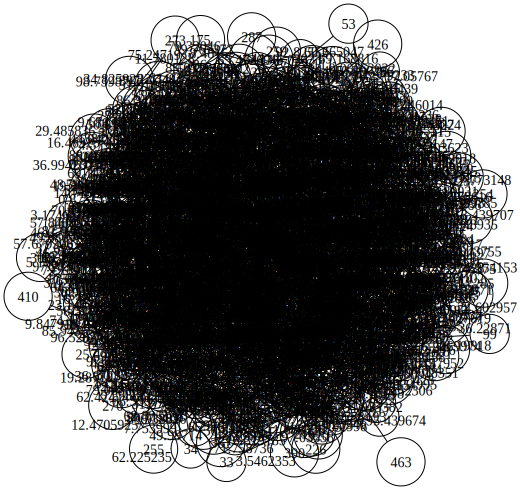

In [6]:
grape.GraphVisualizer(grape_graph).plot_dot()

## Random Walks using GRAPE

In [6]:
start = time.time()
grape_walks_0 = grape_graph.complete_walks(
    walk_length=100,
    iterations=10,
    return_weight=1, # p
    explore_weight=2 # q
)

grape_walks_1 = grape_graph.complete_walks(
    walk_length=100,
    iterations=10,
    return_weight=1, # p
    explore_weight=2 # q
)
end = time.time()
grape_duration = end - start
print(f'Grape duration: {grape_duration:.03f}s')
print(f'Same walks? {np.all(grape_walks_0 == grape_walks_1)}')
print(f'Shape: {grape_walks_0.shape}')

Grape duration: 0.049s
Same walks? True
Shape: (5000, 100)


## Random Walks using PecanPy

In [8]:
pecanpy_graph = pecanpy.SparseOTF(
    p=1,
    q=1,
    workers=8,
    verbose=True
)
pecanpy_graph.read_edg(temp_path, weighted=True, directed=False)

start = time.time()
pecanpy_walks0 = pecanpy_graph.simulate_walks(
    num_walks=10,
    walk_length=100
)
pecanpy_walks1 = pecanpy_graph.simulate_walks(
    num_walks=10,
    walk_length=100
)

end = time.time()
grape_duration = end - start
print(f'Pecanpy duration: {grape_duration:03f}s')
print(f'Same walks? {np.all(np.array(pecanpy_walks0) == np.array(pecanpy_walks1))}')
print(f'Shape: {np.array(pecanpy_walks0).shape}')

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Pecanpy duration: 7.597815s
Same walks? False
Shape: (5000, 101)


## Use walks to learn embeddings with Word2Vec
- PecanPy + Word2Vec are guaranteed to not generate same embeddings because PecanPy's random walks can't be seeded (or at least from what I have tried, see `../pecanpy_test/`).
- GRAPE + Word2Vec can generate the same embeddings on the same graph if Word2Vec only uses 1 worker (much slower)

In [28]:
dimensions = 128

grape_model0 = Word2Vec(
    grape_walks_0.tolist(),
    vector_size=dimensions,
    window=5,
    min_count=0,
    sg=1,
    workers=1,
    epochs=10,
    seed=123
)
grape_model1 = Word2Vec(
    grape_walks_0.tolist(),
    vector_size=dimensions,
    window=5,
    min_count=0,
    sg=1,
    workers=1,
    epochs=10,
    seed=123
)
pecanpy_model0 = Word2Vec(
    pecanpy_walks0,
    vector_size=dimensions,
    window=5,
    min_count=0,
    sg=1,
    workers=1,
    epochs=10,
    seed=123
)
pecanpy_model1 = Word2Vec(
    pecanpy_walks1,
    vector_size=dimensions,
    window=5,
    min_count=0,
    sg=1,
    workers=1,
    epochs=10,
    seed=123
)

In [30]:
print(f'''Grape embeddings similar? : {np.all(grape_model0.wv.vectors == grape_model1.wv.vectors)}''')
print(f'''PecanPy embeddings similar? : {np.all(pecanpy_model0.wv.vectors == pecanpy_model1.wv.vectors)}''')

Grape embeddings similar? : True
PecanPy embeddings similar? : False
